In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
"""

All elements in the batch need to be sorted by their non-padded lengths in descending order
i.e. the first sentence in the batch needs to be the longest.

sort_within_batch which tells the iterator that the contents of the batch need to be sorted
sort_key a function which tells the iterator how to sort the elements in the batch.

"""

BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     # Enable sorting within a batch
     sort_within_batch = True,
     # Tell iterator how to sort elements in a batch
     sort_key = lambda x : len(x.src),
     device = device)

** Reference: https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch

When training RNN (LSTM or GRU or vanilla-RNN), it is difficult to batch the variable length sequences. For ex: if length of sequences in a size 8 batch is [4,6,8,5,4,3,7,8], you will pad all the sequences and that will results in 8 sequences of length 8. You would end up doing 64 computation (8x8), but you needed to do only 45 computations. Moreover, if you wanted to do something fancy like using a bidirectional-RNN it would be harder to do batch computations just by padding and you might end up doing more computations than required.

Instead, pytorch allows us to pack the sequence, internally packed sequence is a tuple of two lists. One contains the elements of sequences. Elements are interleaved by time steps (see example below) and other contains the size of each sequence the batch size at each step. This is helpful in recovering the actual sequences as well as telling RNN what is the batch size at each time step. This has been pointed by @Aerin. This can be passed to RNN and it will internally optimize the computations.

I might have been unclear at some points, so let me know and I can add more explanations.

** Padding is a way to make all the senteces the same legnth by adding extra empty tokens (pads). Packing is way to tell RNN the actual length of padded sentences to reduce the computation time.

In [9]:
seq_batch = [torch.tensor([[1, 1],
                           [2, 2],
                           [3, 3],
                           [4, 4]]),
             torch.tensor([[10, 10],
                           [20, 20]])]

seq_lens = [4, 2]
padded_seq_batch = torch.nn.utils.rnn.pad_sequence(seq_batch, batch_first=True)
print(padded_seq_batch)
torch.nn.utils.rnn.pack_padded_sequence(padded_seq_batch, lengths=seq_lens, batch_first=True)

tensor([[[ 1,  1],
         [ 2,  2],
         [ 3,  3],
         [ 4,  4]],

        [[10, 10],
         [20, 20],
         [ 0,  0],
         [ 0,  0]]])


PackedSequence(data=tensor([[ 1,  1],
        [10, 10],
        [ 2,  2],
        [20, 20],
        [ 3,  3],
        [ 4,  4]]), batch_sizes=tensor([2, 2, 1, 1]))

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        # it takes enc_hid_dim*2 cuz it's bidirectional
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        # src = [src len, batch size]
        # src_len = [batch size]
        # First, embed sentences in a batch
        embedded = self.dropout(self.embedding(src))
        
        # embedded = [src len, batch size, emb dim]
        # pack_padded_sequence takes embedded sentences as input, and returns packed embedded sentences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        
        # Pass packed embeddings to avoid unnecessary computation
        # packed_outputs is a packed sequence containing all hidden states
        # hidden is now from the final non-padded element in the batch
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        # outputs is now a non-packed sequence, all hidden states obtained
        # when the input is a pad token are all zeros
        # outputs will be used in attention
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        # Concatenate forward and backward contexts, which will be used as initial state in decoder
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using masking, we can force the attention to only be over non-padding elements.
This is a [batch size, source sentence length] tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. 
For example, if the source sentence is: ["hello", "how", "are", "you", "?", <pad>, <pad>], then the mask would be [1, 1, 1, 1, 1, 0, 0].
We apply the mask after the attention has been calculated, but before it has been normalized by the softmax function.
Masking is applied to ensure that no attention is payed to pad tokens in the source sentence.

In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # calculate attention weights using all the hidden states from encoder and previous state in decoder
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        # calculate weighted sum of attentional vector; this value will be normalized by softmax later
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]
        # First, calculate weighted sum of attention; this will be asked later
        attention = self.v(energy).squeeze(2)
        
        # attention = [batch size, src len]
        # mask = [batch size, src sentence len], 0 if a token is pad, otherwise 1
        # the second arguemnt of masked_fill is condition, and the second one is the return value if condition meets
        # if a hidden state is masked, it gives infinitesimal value so decoder can avoid paying attention to pad tokens
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    # forward takes mask as argument
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        # src_pad_idx = the index of pad token in source vocab
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        # mask takes a list of tokens
        # it returns 1 if an element is not pad, otherwise 0
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        # must pass src_len to encoder so encoder can pack padded sentences
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        # mask source sentences so attention won't be paid to pad tokens
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

In [30]:
print(SRC.pad_token)
print(SRC.vocab.stoi[SRC.pad_token])

<pad>
1


In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [17]:
optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [18]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        # batch contains src_len values
        # src_len stores the length of each sentence in src
        # src = [src length, batch size]
        src, src_len = batch.src
#         print(src)
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 45s
	Train Loss: 5.188 | Train PPL: 179.069
	 Val. Loss: 4.909 |  Val. PPL: 135.457
Epoch: 02 | Time: 0m 45s
	Train Loss: 4.272 | Train PPL:  71.656
	 Val. Loss: 4.363 |  Val. PPL:  78.473
Epoch: 03 | Time: 0m 45s
	Train Loss: 3.496 | Train PPL:  32.998
	 Val. Loss: 3.646 |  Val. PPL:  38.334
Epoch: 04 | Time: 0m 46s
	Train Loss: 2.907 | Train PPL:  18.306
	 Val. Loss: 3.412 |  Val. PPL:  30.311
Epoch: 05 | Time: 0m 46s
	Train Loss: 2.476 | Train PPL:  11.898
	 Val. Loss: 3.300 |  Val. PPL:  27.113
Epoch: 06 | Time: 0m 45s
	Train Loss: 2.172 | Train PPL:   8.773
	 Val. Loss: 3.254 |  Val. PPL:  25.890
Epoch: 07 | Time: 0m 46s
	Train Loss: 1.940 | Train PPL:   6.957
	 Val. Loss: 3.209 |  Val. PPL:  24.757
Epoch: 08 | Time: 0m 46s
	Train Loss: 1.742 | Train PPL:   5.711
	 Val. Loss: 3.218 |  Val. PPL:  24.984
Epoch: 09 | Time: 0m 46s
	Train Loss: 1.565 | Train PPL:   4.782
	 Val. Loss: 3.329 |  Val. PPL:  27.917
Epoch: 10 | Time: 0m 46s
	Train Loss: 1.432 | Train PPL

In [24]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.201 | Test PPL:  24.552 |


In [25]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)
        # if the prob of eos is the highest, stop generating sentence
        # greedy search in this function
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [29]:
example_idx = 15

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'schwarzem', 'oberteil', 'und', 'brille', 'streut', 'puderzucker', 'auf', 'einem', 'gugelhupf', '.']
trg = ['a', 'lady', 'in', 'a', 'black', 'top', 'with', 'glasses', 'is', 'sprinkling', 'powdered', 'sugar', 'on', 'a', 'bundt', 'cake', '.']


predicted trg = ['a', 'woman', 'in', 'a', 'black', 'shirt', 'and', 'glasses', 'sprinkling', 'sprinkling', 'powdered', 'powdered', 'powdered', 'a', '.', '.', '<eos>']


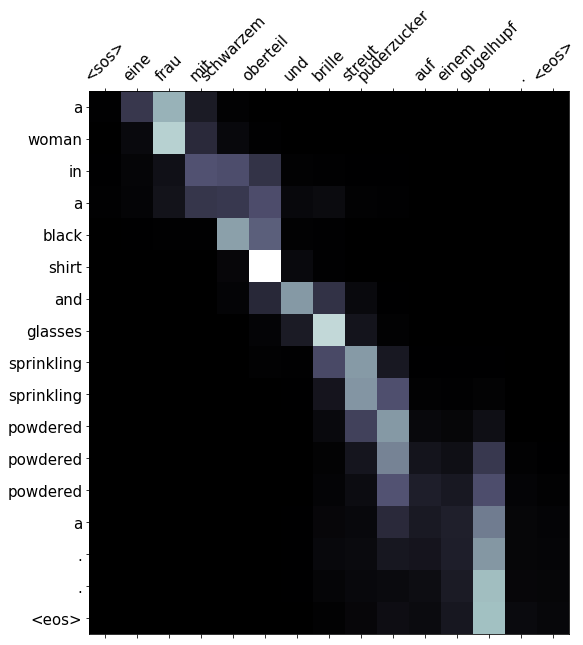

In [30]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [55]:
# %load_ext autoreload
# %autoreload 2
from torchtext.data.metrics import bleu_score

# Usually, BLEU is calculated over multiple candidate translations per source and target sentence (reference)
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    # stores targets
    trgs = []
    # stores predictions (candidate per target)
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        # get translation candidate
        # max_len defines the maximum length of translation
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the higher BLEU score is "better".

In [56]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 30.63
